In [62]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
from utils import *
from PIL import Image
from pathlib import Path
import PIL


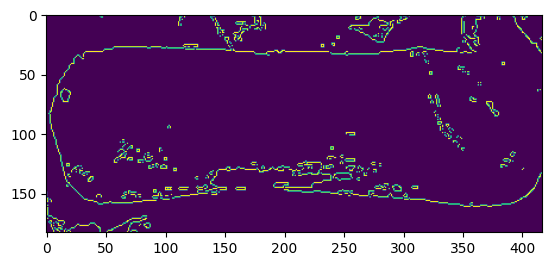

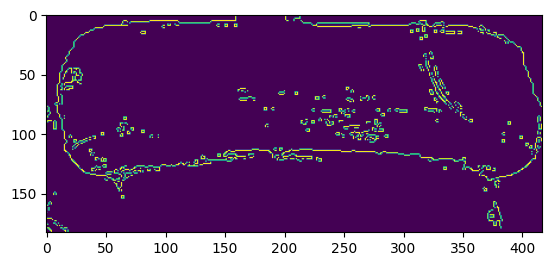

In [74]:
seat = 1
for a in [3]:
    video_path = f'/mnt/FAA/CATR/Pilot/Cabin-aligned/rowL-{a}.mp4'
    video = cv2.VideoCapture(video_path)
    video_name = Path(video_path).stem
    annotations = json.load(open(f"/mnt/FAA/CATR/Pilot/Calibration/oak/images/{video_name}.json",'r'))
    img_shape = (annotations['imageHeight'],annotations['imageWidth'])
    ref_image = img_b64_to_arr(annotations['imageData'])
    bbox_seat = {}
    mask_seat = {}
    mask_seat_back =  []
    bbox_seat_back = []
    seat_color = []
    for ann in annotations["shapes"]:
        mask = shape_to_mask(img_shape, ann['points'])
        bbox = mask_to_box(mask)
        if ann['label'] == 'seat':
            bbox_seat_back.append(bbox)
            mask_seat_back.append(mask)
            ref_mask = ref_image*np.expand_dims(mask,2)
            c = np.ma.masked_equal(ref_mask, 0).mean(axis=(0,1)).data.astype(np.uint8)
            seat_color.append(c)
    curr = 700*15
    for i in range(2):
        video.set(cv2.CAP_PROP_POS_FRAMES, curr)
        ret, frame = video.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_HSV = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
        frame_threshold = cv2.inRange(frame_HSV, (180*0.377, 255*0.000, 255*0.145), (180*0.627, 255*0.755, 255*0.842))

        #PIL.Image.fromarray(frame).save('test.png')
        #new_frame = frame*np.expand_dims(~mask_seat_back[seat],2)
        new_frame = frame_threshold[bbox_seat_back[seat][1]-50:bbox_seat_back[seat][3],bbox_seat_back[seat][0]:bbox_seat_back[seat][2]]
        curr = 59*60*15+800
        edges = cv2.Canny(new_frame,200,300)
        linesP = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, None, 50, 5)

        if linesP is not None:
            for i in range(0, len(linesP)):
                x1,x2,y1,y2 = linesP[i][0]
                angle = np.arctan2(y2 - y1, x2 - x1) * 180. / np.pi
                print(angle)
                if -150<angle<-100:
                    cv2.line(new_frame, (x1,x2), (y1,y2), (0,0,255), 3, cv2.LINE_AA)

        plt.imshow(edges)
        plt.show()
    video.release()

